In [ ]:
import numpy as np
import os
from retinanet import model
from retinanet import coco_eval
from retinanet.dataloader import CocoDataset_inOrder,rehearsal_DataSet, collater, Resizer, AspectRatioBasedSampler, Augmenter, Normalizer
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import collections
import torch
root_path = '/home/deeplab307/Documents/Anaconda/Shiang/CL/'
method = 'w_distillation'
data_split = '15+1'
start_round = 1
batch_size = 1

checkpoint_epoch = 50

def checkDir(path):
    """check whether directory exists or not.If not, then create it 
    """
    if not os.path.isdir(path):
        os.mkdir(path)
def get_checkpoint_path(method, now_round, epoch, data_split ="None"):
    global root_path
    # global data_split
    
    
    checkDir(os.path.join(root_path, 'model', method, 'round{}'.format(now_round)))
    checkDir(os.path.join(root_path, 'model', method, 'round{}'.format(now_round), data_split))
    
    path = os.path.join(root_path, 'model', method, 'round{}'.format(now_round), data_split,'voc_retinanet_{}_checkpoint.pt'.format(epoch))
    return path


def readCheckpoint(method, now_round, epoch, data_split, retinanet, optimizer = None, scheduler = None):
    print('readcheckpoint at Round{} Epoch{}'.format(now_round, epoch))
    prev_checkpoint = torch.load(get_checkpoint_path(method, now_round, epoch, data_split))
    retinanet.load_state_dict(prev_checkpoint['model_state_dict'])
    if optimizer != None:
        optimizer.load_state_dict(prev_checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(prev_checkpoint['scheduler_state_dict'])
    


# coco_path = '/home/deeplab307/Documents/Anaconda/Shiang/CL/DataSet/VOC2012'



# dataset_train = CocoDataset_inOrder(coco_path, set_name='TrainVoc2012', dataset = 'voc',
#                                     transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]),
#                                    data_split=data_split, start_round=start_round)

# # dataset_val = CocoDataset_inOrder(os.path.join(root_path, 'DataSet', 'VOC2012'), set_name="ValVoc2012", dataset = 'voc', 
# #                 transform=transforms.Compose([Normalizer(), Resizer()]), 
# #                 start_round=1, data_split = "20")

dataset_train = CocoDataset_inOrder(os.path.join(root_path, 'DataSet', 'VOC2012'), set_name='TrainVoc2012', dataset = 'voc',
                                    transform=transforms.Compose([Normalizer(), Resizer()]),
                                   data_split=data_split, start_round=start_round)
retinanet = model.resnet50(num_classes=dataset_train.num_classes(), pretrained=True)
retinanet.cuda()

#sampler = AspectRatioBasedSampler(dataset_train, batch_size = batch_size, drop_last=False)
# # dataloader_train = DataLoader(dataset_train, num_workers=2, collate_fn=collater, batch_sampler=sampler)



optimizer = optim.Adam(retinanet.parameters(), lr=1e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
# loss_hist = collections.deque(maxlen=500)

readCheckpoint(method, start_round, checkpoint_epoch,data_split, retinanet)

In [ ]:
import random
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
import numpy as np
def collater(data):

    imgs = [s['img'] for s in data]
    annots = [s['annot'] for s in data]
    scales = [s['scale'] for s in data]
        
    widths = [int(s.shape[0]) for s in imgs]
    heights = [int(s.shape[1]) for s in imgs]
    batch_size = len(imgs)

    max_width = np.array(widths).max()
    max_height = np.array(heights).max()

    padded_imgs = torch.zeros(batch_size, max_width, max_height, 3)

    for i in range(batch_size):
        img = imgs[i]
        padded_imgs[i, :int(img.shape[0]), :int(img.shape[1]), :] = img

    max_num_annots = max(annot.shape[0] for annot in annots)
    
    if max_num_annots > 0:

        annot_padded = torch.ones((len(annots), max_num_annots, 5)) * -1

        if max_num_annots > 0:
            for idx, annot in enumerate(annots):
                if annot.shape[0] > 0:
                    annot_padded[idx, :annot.shape[0], :] = annot
    else:
        annot_padded = torch.ones((len(annots), 1, 5)) * -1


    padded_imgs = padded_imgs.permute(0, 3, 1, 2)

    return {'img': padded_imgs, 'annot': annot_padded, 'scale': scales}

class AspectRatioBasedSampler(Sampler):

    def __init__(self, data_source, batch_size, drop_last):
        self.data_source = data_source
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.groups = self.group_images()

    def __iter__(self):
        random.shuffle(self.groups)
        for group in self.groups:
            yield group

    def __len__(self):
        if self.drop_last:
            return len(self.data_source) // self.batch_size
        else:
            return (len(self.data_source) + self.batch_size - 1) // self.batch_size

    def group_images(self):
        # determine the order of the images
        order = list(range(len(self.data_source)))
        order.sort(key=lambda x: self.data_source.image_aspect_ratio(x))

        # divide into groups, one group = one batch
        return [[order[x % len(order)] for x in range(i, i + self.batch_size)] for i in range(0, len(order), self.batch_size)]

class A_GEM(object):
    def __init__(self, model, replay_dataset, batch_sample = 5):
        self.memory = replay_dataset
        self.model = model
        self.batch_sample = batch_sample
        self.replay_grad = None
        self.update_dataLoader()
        
    def cal_replay_grad(self, optimizer):
        #print("calculate replay grad!")
        self.replay_grad = []
        #data = self.dataLoader.__iter__().next()
        
        num_groups = len(self.sampler.groups)
        for group in self.sampler.groups:
            data = []
            for idx in group:
                data.append(self.sampler.data_source[idx])
            data = collater(data)
            temp = []
            try:
                optimizer.zero_grad()
                prev_status = self.model.distill_loss
                self.model.distill_loss = False
                with torch.cuda.device(0):
                    classification_loss, regression_loss = self.model([data['img'].float().cuda(), data['annot'].cuda()])
                    classification_loss = classification_loss.mean()
                    regression_loss = regression_loss.mean()
                    loss = classification_loss + regression_loss
                    loss.backward()
                    print('Replay Data: Classification loss: {:1.5f} | Regression loss: {:1.5f}'.format(float(classification_loss), float(regression_loss)))
                    for name, p in self.model.named_parameters():
                        if "prev_model" not in name and "bn" not in name and p.requires_grad:
                            temp.append(p.grad.view(-1))
                    
                    temp = torch.cat(temp) / num_groups
                    if self.replay_grad == []:
                        self.replay_grad = temp
                    else:
                        self.replay_grad += temp
                        
                        
                    del temp
                    del classification_loss, regression_loss
                optimizer.zero_grad()
            except Exception as e:
                print(e)
                continue
        
#             self.cal_replay_grad(optimizer)
        self.model.distill_loss = prev_status
    
    def fix_grad(self):
        # cal current gradient
        cur_grad = []
        for name, p in self.model.named_parameters():
            if "prev_model" not in name and "bn" not in name and p.requires_grad:
                cur_grad.append(p.grad.view(-1))
        cur_grad = torch.cat(cur_grad)
        length_replay = (self.replay_grad * self.replay_grad).sum() # the vector of replay_grad's length 
        angle = (cur_grad * self.replay_grad).sum() # the two gradient's angle
        
        
        # update grad
        if angle < 0:
            proj_grad = cur_grad - ((angle / length_replay) * self.replay_grad) # project gradient
            #proj_grad = torch.where(torch.ge(angle, 0), cur_grad, proj_grad)
            index = 0
            for name, p in self.model.named_parameters():
                if "prev_model" not in name and "bn" not in name and p.requires_grad:
                    n_param = p.numel()  # number of parameters in [p]
                    p.grad.copy_(proj_grad[index:index+n_param].view_as(p))
                    index += n_param
            del proj_grad
        del cur_grad, self.replay_grad
            
    def update_dataLoader(self):
        self.sampler = AspectRatioBasedSampler(self.memory, batch_size = self.batch_sample, drop_last=False)
        #self.dataLoader = DataLoader(self.memory, num_workers=2, collate_fn=collater, batch_sampler=sampler) 



In [ ]:
rehearsal_dataset = rehearsal_DataSet('/home/deeplab307/Documents/Anaconda/Shiang/CL/DataSet/VOC2012', set_name='TrainVoc2012', dataset = 'voc',
                        transform=transforms.Compose([Normalizer(), Resizer()]), 
                        data_split = "15+1",method = "random", per_num = 2)
rehearsal_dataset.reset_by_round(2)

In [ ]:
sampler = AspectRatioBasedSampler(rehearsal_dataset, batch_size = 5, drop_last=False)

In [ ]:
for group in sampler.groups:
    data = []
    for idx in group:
        data.append(sampler.data_source[idx])
    data = collater(data)

In [ ]:
agem = A_GEM(retinanet, rehearsal_dataset, 5)

In [ ]:
agem.cal_replay_grad(optimizer)

# 修改sample的data

In [ ]:
from retinanet.dataloader import CocoDataset_inOrder,rehearsal_DataSet, collater, Resizer, AspectRatioBasedSampler, Augmenter, Normalizer
from torchvision import transforms
rehearsal_dataset = rehearsal_DataSet('/home/deeplab307/Documents/Anaconda/Shiang/CL/DataSet/VOC2012', set_name='TrainVoc2012', dataset = 'voc',
                        transform=transforms.Compose([Normalizer(), Resizer()]), 
                        data_split = "15+1",method = "random", per_num = 2)
rehearsal_dataset.reset_by_round(2)

In [ ]:
rehearsal_dataset.cocoHelper.catNameToId('cat')

In [ ]:
import random
import matplotlib.pyplot as plt

imgIds = rehearsal_dataset.coco.getImgIds(catIds=17)
random.shuffle(imgIds)

i = 1
for imgId in imgIds:
    print(imgId)
    im = cv2.imread(os.path.join(img_path, str(imgId)[:4] + '_' + str(imgId)[4:] +'.jpg'))
    plt.figure(figsize=(7,7))
    plt.imshow(im)
    i += 1
    if i == 15:
        break

In [ ]:
from collections import defaultdict
catIds = rehearsal_dataset.classOrder['id'][0]

names = rehearsal_dataset.cocoHelper.catIdToName(catIds)
print(names)

sample = defaultdict(list)
i = 0

for name in names:
    for _ in range(2):
        sample[name].append(rehearsal_dataset.image_ids[i])
        i += 1

In [ ]:
rehearsal_dataset.

In [ ]:
sample = {'person': [2008001302],
         'car': [2010004059],
         'bicycle': [2008004603],
         'bus':     [2009004871], 
         'motorbike': [2010004848],
         'aeroplane': [2011001871],
         'boat':  [2008008616],
         'chair': [2010002870],
         'bottle': [2009005057],
         'diningtable': [2010003078],
         'bird': [2008006923],
         'cat': [2009001948],
         'cow': [2009003510],
         'dog': [2008001479],
         'horse': [2010004247]}

samples = []
for v in sample.values():
    samples.extend(v)
print(samples)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
img_path = "/home/deeplab307/Documents/Anaconda/Shiang/CL/DataSet/VOC2012/images"

per_num =1



plt.figure(figsize=(4*per_num,50))
gs = gridspec.GridSpec(len(samples) // per_num, per_num)
i, j = 0, 0
for imgId in samples:
    im = cv2.imread(os.path.join(img_path, str(imgId)[:4] + '_' + str(imgId)[4:] +'.jpg'))
    plt.subplot(gs[i,j])
    plt.imshow(im)
    j += 1
    if j == per_num:
        j = 0
        i += 1

In [ ]:
sample = {'person': [2008002080, 2008001302],
         'car': [2010004059, 2010001043],
         'bicycle': [2009004340, 2008004603],
         'bus':     [2009004871, 2009004383], 
         'motorbike': [2010004848, 2011000233],
         'aeroplane': [2009001541, 2008007629],
         'boat':  [2008002850, 2008008616],
         'chair': [2010004660, 2010002870],
         'bottle': [2008006004, 2009005057],
         'diningtable': [2011002818, 2010003078],
         'bird': [2009001751, 2010003929],
         'cat': [2009005037, 2009005177],
         'cow': [2008008521, 2008008121],
         'dog': [2010000484, 2008001479],
         'horse': [2010004247, 2009001147]}

samples = []
for v in sample.values():
    samples.extend(v)
print(samples)

In [7]:
plt.figure(figsize=(4*per_num,50))
gs = gridspec.GridSpec(len(samples) // per_num, per_num)

<Figure size 576x3600 with 0 Axes>

In [13]:
len(rehearsal_dataset.image_ids)

30

0 2
0 3
1 2
1 3
2 2
2 3
3 2
3 3
4 2
4 3
5 2
5 3
6 2
6 3
7 2
7 3
8 2
8 3
9 2
9 3
10 2
10 3
11 2
11 3
12 2
12 3
13 2
13 3
14 2
14 3


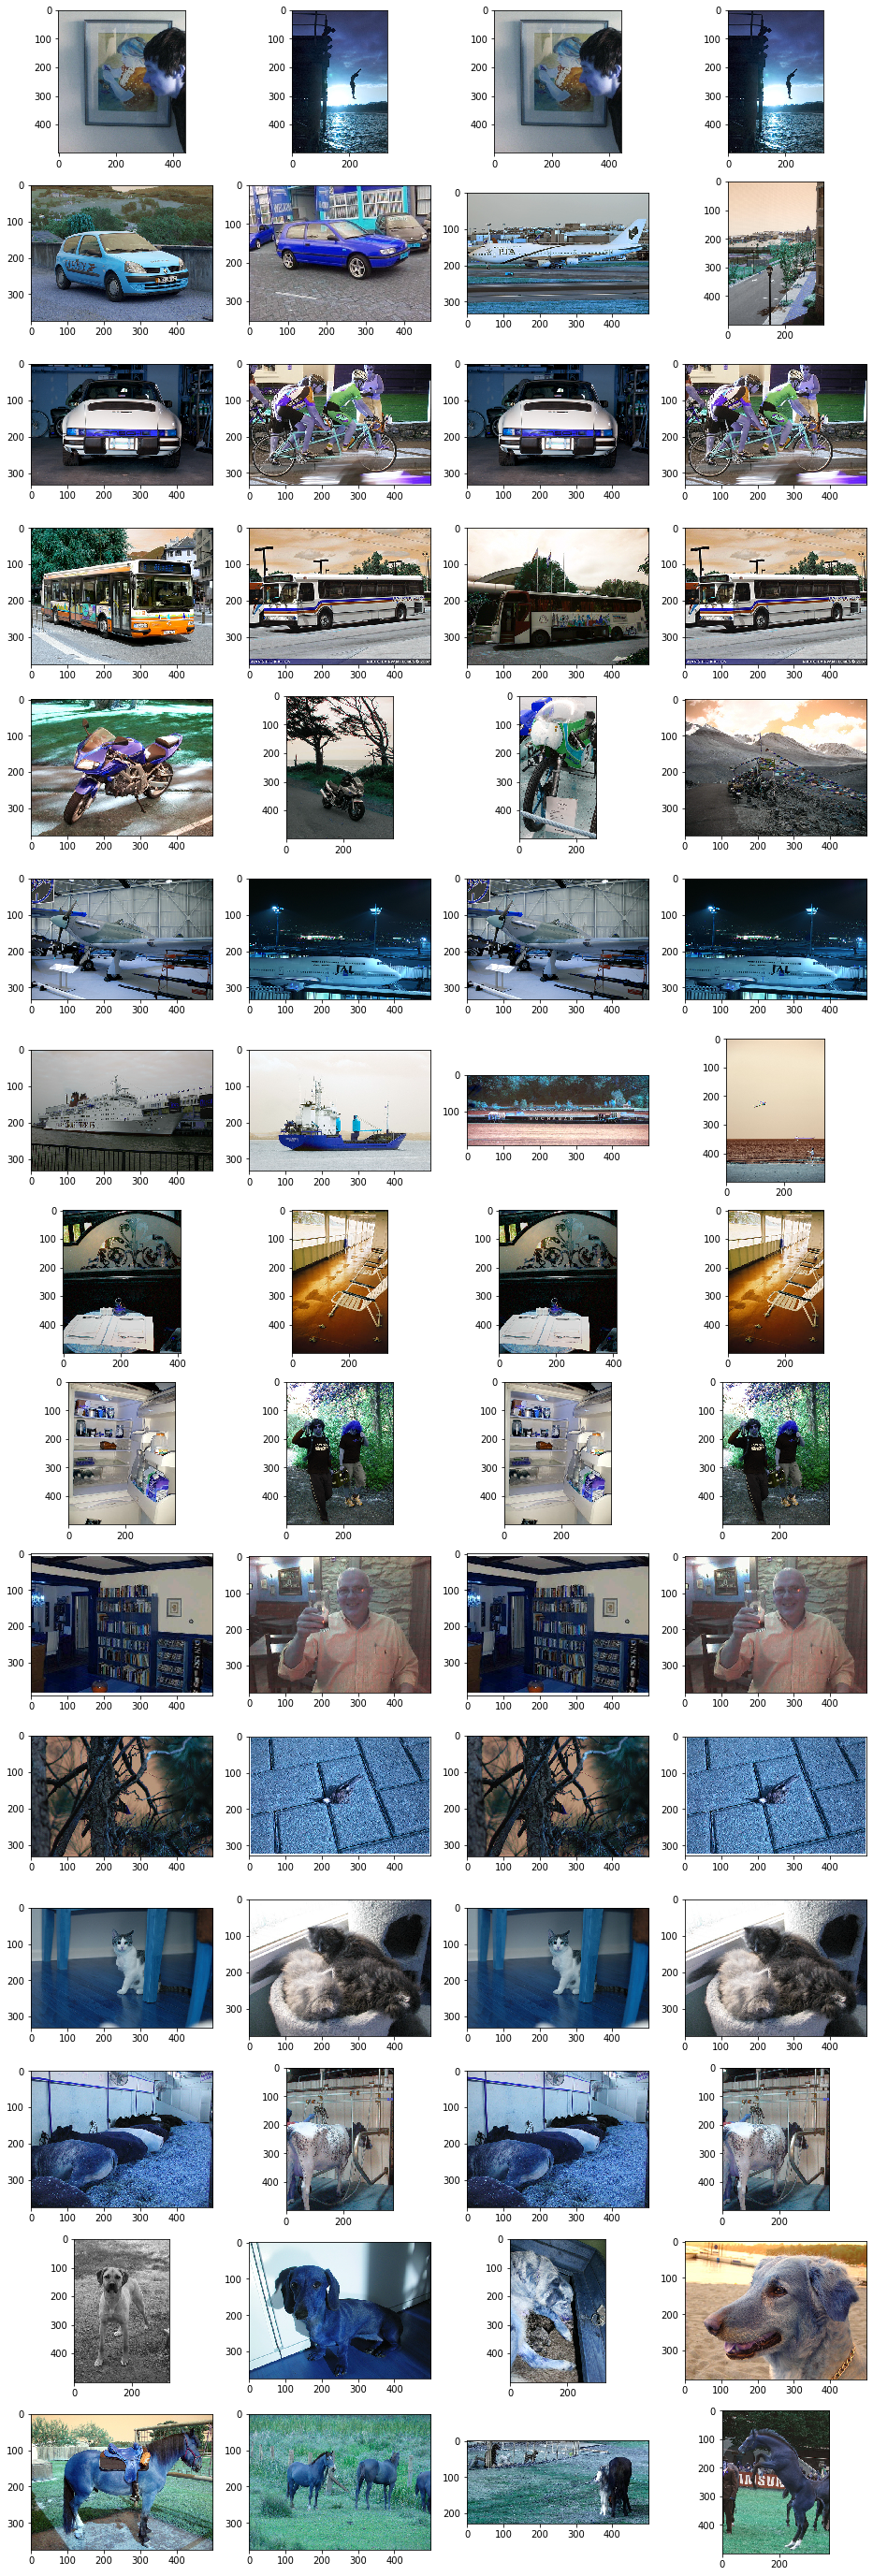

In [16]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
img_path = "/home/deeplab307/Documents/Anaconda/Shiang/CL/DataSet/VOC2012/images"

per_num = 4

plt.figure(figsize=(4*per_num,50))
gs = gridspec.GridSpec(len(samples)*2 // per_num, per_num)
i, j = 0, 0


replay_id = 0
for imgId in samples:
    im = cv2.imread(os.path.join(img_path, str(imgId)[:4] + '_' + str(imgId)[4:] +'.jpg'))
    plt.subplot(gs[i,j])
    plt.imshow(im)
    j += 1

    if j == 2:
        for _ in range(2):
            imgId = rehearsal_dataset.image_ids[replay_id]
            im = cv2.imread(os.path.join(img_path, str(imgId)[:4] + '_' + str(imgId)[4:] +'.jpg'))
            plt.subplot(gs[i,j])
            plt.imshow(im)
            j += 1
            replay_id += 1
    
    if j == per_num:
        j = 0
        i += 1

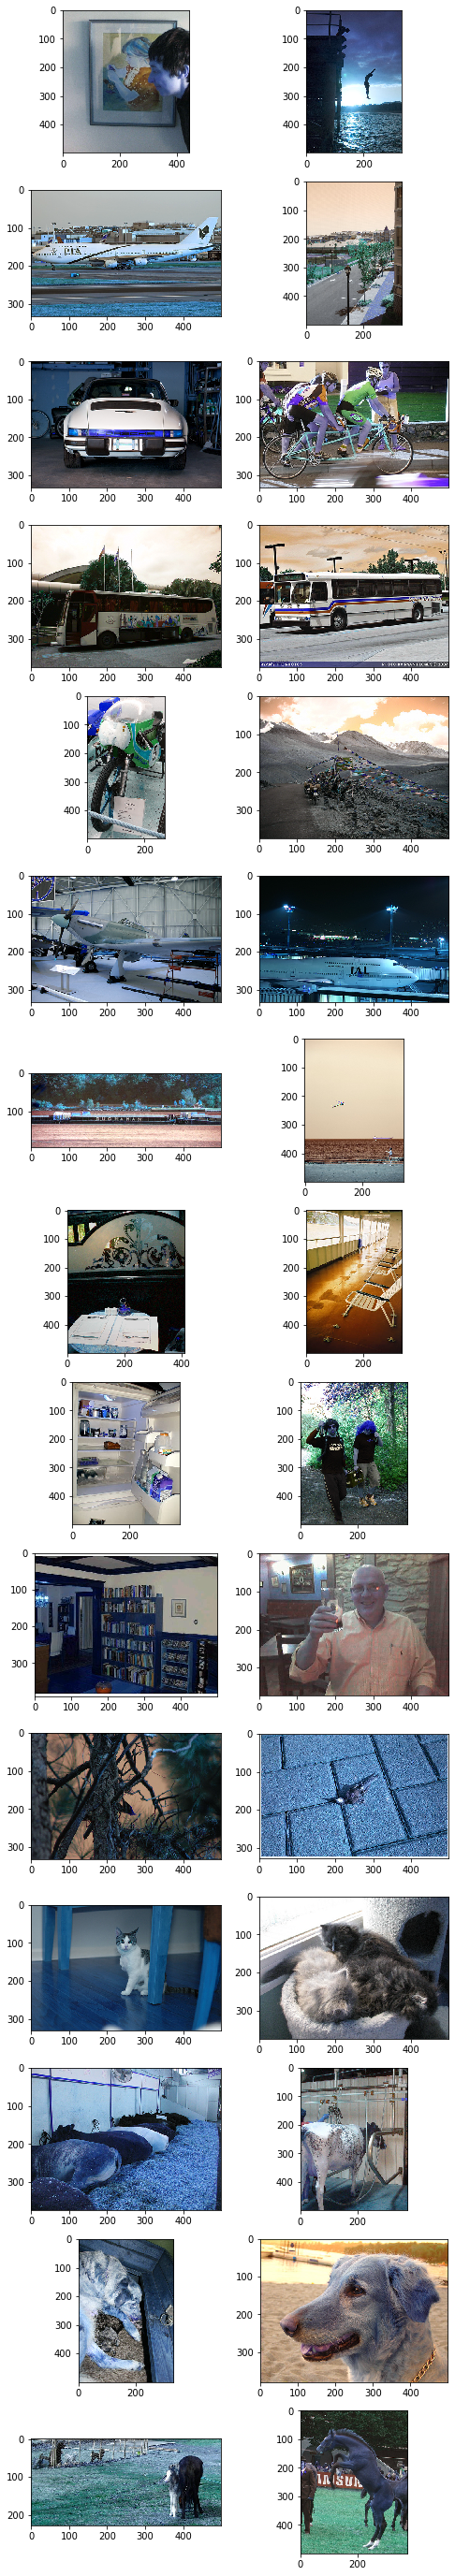

In [5]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
img_path = "/home/deeplab307/Documents/Anaconda/Shiang/CL/DataSet/VOC2012/images"

per_num =2

plt.figure(figsize=(4*per_num,50))
gs = gridspec.GridSpec(len(samples) // per_num, per_num)
i, j = 0, 0
for imgId in rehearsal_dataset.image_ids:
    im = cv2.imread(os.path.join(img_path, str(imgId)[:4] + '_' + str(imgId)[4:] +'.jpg'))
    plt.subplot(gs[i,j])
    plt.imshow(im)
    j += 1
    if j == per_num:
        j = 0
        i += 1

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2
import matplotlib.gridspec as gridspec
i = 0
cat_name = 'motorbike'
img_path = "/home/deeplab307/Documents/Anaconda/Shiang/CL/DataSet/VOC2012/images"
future_class_id = []
for i in range(1, len(rehearsal_dataset.classOrder['id'])):
    future_class_id.extend(rehearsal_dataset.classOrder['id'][i])

future_imgIds = set(rehearsal_dataset.cocoHelper.getImgIdFromCats(future_class_id))

imgIds = rehearsal_dataset.cocoHelper.getImgIdFromCats(catIds=rehearsal_dataset.cocoHelper.catNameToId(cat_name))

imgIds = list(set(imgIds) - set(future_imgIds)) 

random.shuffle(imgIds)
for imgId in imgIds:
    im = cv2.imread(os.path.join(img_path, str(imgId)[:4] + '_' + str(imgId)[4:] +'.jpg'))
    plt.figure()
    plt.title(imgId)
    plt.imshow(im)
    i += 1
    if i == 20:
        break

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
img_path = "/home/deeplab307/Documents/Anaconda/Shiang/CL/DataSet/VOC2012/images"

catIds = rehearsal_dataset.classOrder['id'][0]
names = rehearsal_dataset.cocoHelper.catIdToName(catIds)
print(names)
per_num = 1

plt.figure(figsize=(4*per_num,50))
gs = gridspec.GridSpec(len(rehearsal_dataset.image_ids) // per_num, per_num)
i, j = 0, 0
for imgId in rehearsal_dataset.image_ids:
    im = cv2.imread(os.path.join(img_path, str(imgId)[:4] + '_' + str(imgId)[4:] +'.jpg'))
    plt.subplot(gs[i,j])
    plt.imshow(im)
    j += 1
    if j == per_num:
        j = 0
        i += 1

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

img_path = "/home/deeplab307/Documents/Anaconda/Shiang/CL/DataSet/VOC2012/images"

names = [name for name in rehearsal_dataset.classOrder['id'][:15]]
print(names)




plt.figure(figsize=(8,50))
gs = gridspec.GridSpec(len(rehearsal_dataset.image_ids) // 2, 2)
i, j = 0, 0
for imgId in rehearsal_dataset.image_ids:
    im = cv2.imread(os.path.join(img_path, str(imgId)[:4] + '_' + str(imgId)[4:] +'.jpg'))
    plt.subplot(gs[i,j])
    plt.imshow(im)
    j += 1
    if j == 2:
        j = 0
        i += 1

In [ ]:
import matplotlib.pyplot as plt
import cv2

img_path = "/home/deeplab307/Documents/Anaconda/Shiang/CL/DataSet/VOC2012/images"

names = [name for name in rehearsal_dataset.classOrder['name'][:15]]
print(names)
for imgId in rehearsal_dataset.image_ids:
    print(imgId)
    im = cv2.imread(os.path.join(img_path, str(imgId)[:4] + '_' + str(imgId)[4:] +'.jpg'))
    plt.figure()
    plt.imshow(im)

In [ ]:
import matplotlib.pyplot as plt
import cv2

img_path = "/home/deeplab307/Documents/Anaconda/Shiang/CL/DataSet/VOC2012/images"


names = [name for name in rehearsal_dataset.classOrder['name'][:15]]
print(names)
for imgId in rehearsal_dataset.image_ids:

    im = cv2.imread(os.path.join(img_path, str(imgId)[:4] + '_' + str(imgId)[4:] +'.jpg'))
    plt.figure()
    plt.imshow(im)

# 檢查模型間參數的差異

In [ ]:
retinanet = model.resnet50(num_classes=16, pretrained=True)
retinanet_upper = model.resnet50(num_classes=16, pretrained=True)
retinanet15 = model.resnet50(num_classes=15, pretrained=True)
readCheckpoint("w_distillation", now_round = 2, epoch = 50, data_split="15+1",retinanet=retinanet)
readCheckpoint("special_try", now_round = 1, epoch = 50, data_split="custom",retinanet=retinanet_upper)
readCheckpoint("w_distillation", now_round = 1, epoch = 50, data_split="15+1",retinanet=retinanet15)

In [ ]:
def get_names(model):
    names = []
    for name,parameters in model.named_parameters():
        names.append(name)
    return names
names = get_names(retinanet)

In [ ]:
import torch.nn as nn
from collections import defaultdict
MSE = nn.MSELoss()
L1 = nn.L1Loss()

diffs_for_15 = defaultdict(float)
diffs = defaultdict(float)
for name in names:
    if "classificationModel.output" not in name:
        diff = MSE(retinanet_upper.state_dict()[name], retinanet15.state_dict()[name])
        diffs_for_15[name] = float(diff)
    diff = MSE(retinanet.state_dict()[name], retinanet_upper.state_dict()[name])
    diffs[name] = float(diff)


In [ ]:
def print_rank(diffs):
    diffs_keys = [key for key in diffs.keys()]
    diffs_values = list(diffs.values())
    ascending = sorted(range(len(diffs)), key=lambda k: diffs_values[k])
    
    num = 100
    
    for idx in ascending[len(ascending) - num:]:
        print(diffs_keys[idx], diffs_values[idx])

# 計算所有data loss

In [ ]:
import time
import pickle
retinanet.train()
retinanet.freeze_bn()

dataset = dataset_train

fail_id = []
losses = collections.defaultdict(list)

for idx, data in enumerate(dataset):
    start = time.time()
    try:
        optimizer.zero_grad()
        with torch.cuda.device(0):
            if torch.cuda.is_available():
                classification_loss, regression_loss = retinanet([data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0), data['annot'].cuda().unsqueeze(dim=0)])
            else:
                print('not have gpu')
                break

            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()

            img_id = dataset.image_ids[idx]


            classification_loss = float(classification_loss)
            regression_loss = float(regression_loss)
            loss = classification_loss + regression_loss

            losses[img_id] = [classification_loss, regression_loss, loss]

            #optimizer.step()
            loss_hist.append(float(loss))

            #epoch_loss.append(float(loss))
            end = time.time()

            print('Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f} | Spend Time:{:1.2f}s'.format(
                                              '50', 
                                              idx, 
                                              float(classification_loss), 
                                              float(regression_loss), 
                                              np.mean(loss_hist),
                                              end - start))
            del classification_loss
            del regression_loss
    except Exception as e:
        print(e)
        fail_id.append(idx)
        continue

print('fail_id:',fail_id)


with open(os.path.join("/".join(get_checkpoint_path(method, 1, 50).split('/')[:-1]), 'losses.pickle'), 'wb') as f:
    pickle.dump(losses, f)
#print(losses)

In [ ]:
img = dataset_train.load_image(74)
ann = dataset_train.load_annotations(74)
data = {'img': img, 'annot': ann}
data = dataset_train.transform(data)

In [ ]:
data['annot'].cuda().unsque`eze(dim=0).shape

In [ ]:
dataset_train.cocoHelper.classes

In [ ]:
retinanet.each_cat_loss = True
classification_loss, _ = retinanet([data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0), data['annot'].cuda().unsqueeze(dim=0)])

In [ ]:
classification_loss

# 分別為每個類別計算loss

In [ ]:
import time
import pickle
import numpy as np
retinanet.train()
retinanet.freeze_bn()

dataset = dataset_train

fail_id = []
losses = [collections.defaultdict() for _ in dataset.seen_class_id]

retinanet.each_cat_loss = True
for idx, data in enumerate(dataset):

    try:
        with torch.cuda.device(0):
            if torch.cuda.is_available():
                classification_loss, _ = retinanet([data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0), data['annot'].cuda().unsqueeze(dim=0)])
            else:
                print('not have gpu')
                break


            img_id = dataset.image_ids[idx]

            for key in classification_loss.keys():
                losses[key][img_id] = float(np.mean(classification_loss[key]))

            print(idx)

    except Exception as e:
        print(e)
        fail_id.append(idx)
        continue

print('fail_id:',fail_id)


with open(os.path.join("/".join(get_checkpoint_path(method, 1, 50,data_split).split('/')[:-1]), 'losses_each_cat_new.pickle'), 'wb') as f:
    pickle.dump(losses, f)
#print(losses)

In [ ]:
classification_loss.keys()

In [ ]:
from collections import defaultdict

In [ ]:
with open(os.path.join("/".join(get_checkpoint_path(method, 1, 50,data_split).split('/')[:-1]), 'losses_each_cat.pickle'), 'rb') as f:
    losses = pickle.load(f)

In [ ]:
for i in losses:
    print(len(i))

In [ ]:
losses

In [ ]:
os.path.join("/".join(get_checkpoint_path(method, 1, 50).split('/')[:-1]), 'losses.pickle')

In [ ]:
losses = [v[2] for v in losses.values()]

In [ ]:
method = 'w_distillation'

for i in range(50,51,10):
    print(np.mean(readCheckpoint(method, 1, i)))



In [ ]:
method = 'incremental'

for i in range(10,31,10):
    print(np.mean(readCheckpoint(method, 1, i)))

In [ ]:
method = 'incremental'

for i in range(10,51,10):
    print(np.mean(readCheckpoint(method, 0, i)))



In [ ]:
np.mean(readCheckpoint(method, 0, i)

In [ ]:
parts = []

for i in range(0,4):
    parts.append(retinanet.classificationModel.output.weight.data[i*9: i*9 + 9,:,:,:])

In [ ]:
import torch.nn as nn
output = nn.Conv2d(256, 9 * 20, kernel_size=3, padding=1)

In [ ]:
output.weight.data[0:9,:,:,:] = parts[3]
#vehicle(7)
for i in range(0,7):
    output.weight.data[9 + i*9:9 + i*9 + 9,:,:,:] = parts[0]
#furniture(6)
for i in range(0,6):
    output.weight.data[72 + i*9:72 + i*9 + 9,:,:,:] = parts[1]
#animals(6)
for i in range(0,6):
    output.weight.data[126 + i*9:126 + i*9 + 9,:,:,:] = parts[2]

In [ ]:
(output.weight.data[72:81,:,:,:] == output.weight.data[81:90,:,:,:]).any()

In [ ]:
import copy
prev_model = copy.deepcopy(retinanet)
retinanet.increase_class(1)

retinanet.cuda()
prev_model.cuda()

In [ ]:
import torch
test = torch.ones(2,256,30,30).cuda()

In [ ]:
prev_out = prev_model.classificationModel.output_act(prev_model.classificationModel.output(test))
cur_out = retinanet.classificationModel.output_act(retinanet.classificationModel.output(test))

In [ ]:

def change_shape1(out, num_classes):
    out1 = out.permute(0, 2, 3, 1)
    batch_size, width, height, channels = out1.shape
    out1 = out1.view(batch_size, width, height, 9, num_classes)
    
    return out1.contiguous().view(2, -1, num_classes)
def change_shape2(out, num_classes):
    out1 = out.permute(0, 2, 3, 1)
    batch_size, width, height, channels = out1.shape
    out1 = out1.view(batch_size, width, height,num_classes, 9)
    
    out1 = out1.permute(0, 1, 2, 4, 3)
    
    return out1.contiguous().view(2, -1, num_classes)
prev_out_new1 = change_shape1(prev_out, 19)
cur_out_new1 = change_shape1(cur_out, 20)

# prev_out_new2 = change_shape2(prev_out, 19)
# cur_out_new2 = change_shape2(cur_out, 20)
# (prev_out == cur_out[:,:171,:,:]).any()